In [2]:
# from shutil import copyfile 

# copyfile(src= "../input/yolov1-py-files/dataset.py", dst = "./dataset.py")
# copyfile(src= "../input/yolov1-py-files/loss.py", dst = "./loss.py")
# copyfile(src= "../input/yolov1-py-files/model.py", dst = "./model.py")
# copyfile(src= "../input/yolov1-py-files/train.py", dst = "./train.py")
# copyfile(src= "../input/yolov1-py-files/utils.py", dst = "./utils.py")
# from train import *
# from dataset import *
# from model import *
# from loss import * 
# from utils import * 
# import torch
# !python3 "../input/yolov1-py-files/train.py"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import torch
import torch.nn as nn

# Visualize Images :

In [4]:
def yolobbox2bbox(x,y,w,h):
    x1, y1 = x-w/2, y-h/2
    x2, y2 = x+w/2, y+h/2
    return x1, y1, x2, y2
def plot_img(img_name):
    img = cv2.imread( '../input/pascalvoc-yolo/images/'+img_name+'.jpg')
    data = np.loadtxt('../input/pascalvoc-yolo/labels/'+img_name+'.txt')
    data = data.reshape(-1,5)
    for i in range(len(data)):  
        x1,y1,x2,y2 = yolobbox2bbox(data[i][1], data[i][2], data[i][3], data[i][4])
        x1, x2, y1, y2 = int(x1 * img.shape[1]), int(x2 * img.shape[1]), int(y1 * img.shape[0]), int(y2 * img.shape[0])
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,0,255), 2)
#         plt.imshow(img[:,:,::-1])
    return img[:,:,::-1]

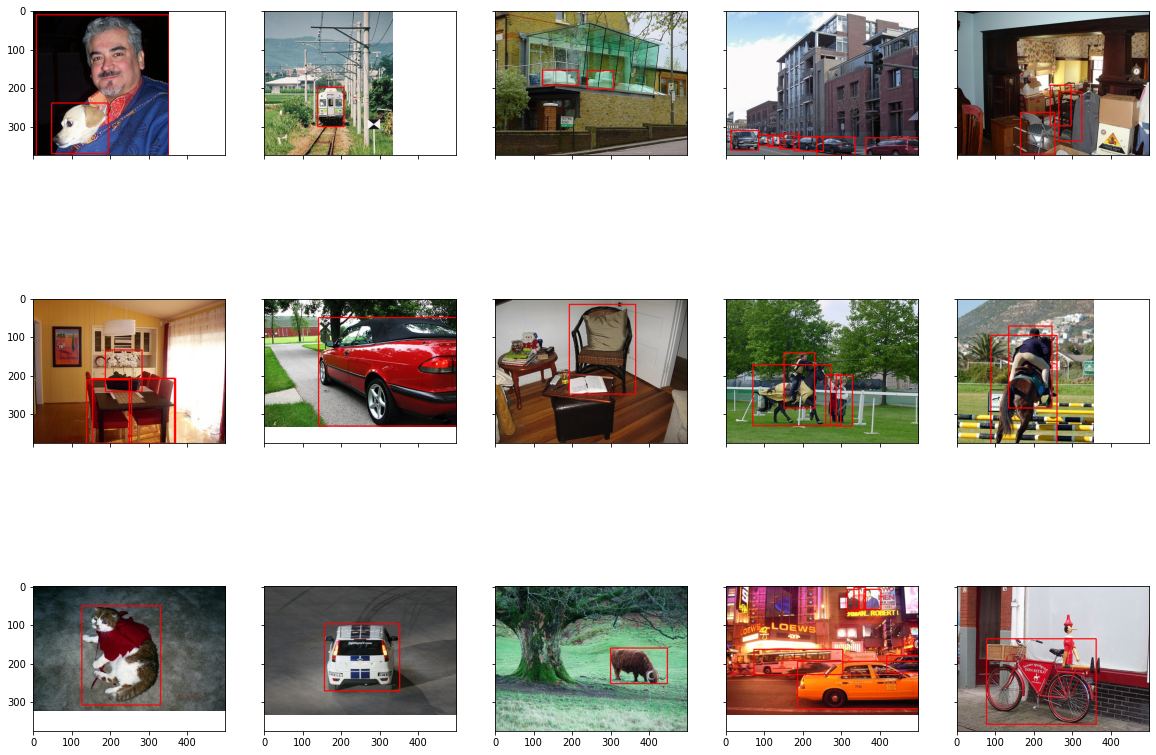

In [5]:
n = 1
rows = 3
cols = 5
fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(20,15))
for row in range(rows):
    for col in range(cols):
        ax[row,col].imshow(plot_img('0000'+str(n if len(str(n)) == 2 else '0'+str(n))))
        n += 1

In [6]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter


def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
               or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
               < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


def mean_average_precision(
        pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        # TP_cumsum & FP_cmsum is a Tensor with multiple values.
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        # At each index it contain precision & recall for a sample.
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        # concating 0 & 1 at the start
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration.
        # It integrates y wrt x.
        ap = torch.trapz(y=precisions, x=recalls)
        average_precisions.append(ap)

    return sum(average_precisions) / len(average_precisions)


def plot_image(image, boxes):
    # pascal voc labels as per id
    pascal_voc_labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                         'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                         'dog', 'horse', 'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor']

    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

    # Each box is of format : [class_label,object_prob,x,y,w,h]

    # Create a Rectangle potch
    for box in boxes:
        box_label = pascal_voc_labels[int(box[0])]
        obj_prob = round((box[1] * 100), 1)
        bbox_label = box_label + " : " + str(obj_prob) + "%"

        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1.5,
            edgecolor="lime",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

        # Displays object name on bbox
        rx, ry = rect.get_xy()
        ax.annotate(bbox_label, (rx, ry), color='white', backgroundcolor='lime',
                    weight='bold', fontsize=6, ha='left', va='bottom')

    plt.show()


# Converts the labels from relative to each
# cell, to relative to the entire image.
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes


# Given loader and model, returns all predicted & ground truth bboxes.
# We'll use it to evaluate the model mAP.
def get_bboxes(
        loader,
        model,
        iou_threshold,
        threshold,
        pred_format="cells",
        box_format="midpoint",
        device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            # We'll bring all predicted & ground truth boxes to format :
            # [train_idx, class_prediction, prob_score, x1, y1, x2, y2]

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


# Functions for saving the model
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [7]:
"""
Implementation of Yolo (v1) architecture
with slight modification with added BatchNorm.

==> MODEL SUMMARY :

Total params: 85,787,534
Trainable params: 85,787,534
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.30
Forward/backward pass size (MB): 436.81
Params size (MB): 327.25
Estimated Total Size (MB): 766.36
----------------------------------------------------------------
"""


import torch
import torch.nn as nn

""" 
Information about architecture config:
Tuple is structured by (kernel_size, filters, stride, padding) 
"M" is simply maxpooling with stride 2x2 and kernel 2x2
List is structured by tuples and lastly int with number of repeats
"""

architecture_config = [

    # (kernel_size, filters, stride, padding)

    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))


"""
The model takes a batch of Images : (Batch_size,Channels,Height,Width).
Flattened_tensor = S * S * (C + B * 5)
Returns a tensor of shape : (Batch_size,Flattened_tensor).
The Flattened tensor can be reshaped to SxSx(C + B*5) 
to get the output tensor for each image.
"""


class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),)

In [8]:
"""
Implementation of Yolo Loss Function from the original yolo paper
"""

import torch
import torch.nn as nn

"""
Output of each grid cell with 20 classes & 2 bounding boxes : 
[0,1,2...19,P1,X1,Y1,X2,Y2,P2,X1,Y1,X2,Y2]
"""


class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) ) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * ((bestbox * predictions[..., 26:30]+ (1 - bestbox) * predictions[..., 21:25]))

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),)

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21])

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        # max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        # no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        # )

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2, ),
            torch.flatten(exists_box * target[..., :20], end_dim=-2, ),
        )

        loss = (self.lambda_coord * box_loss  # first two rows in paper
                + object_loss  # third row in paper
                + self.lambda_noobj * no_object_loss  # forth row
                + class_loss )  # fifth row

        return loss

In [9]:
"""
Creates a Pytorch dataset to load the Pascal VOC dataset
"""

import torch
import os
import pandas as pd
from PIL import Image


"""
pascal_voc_labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                     'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                     'dog', 'horse', 'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']
"""


# Takes 3 main parameters :
# 1] csv file containing img & label file names.
# 2] dir paths of where images & their labels are located.
# 3] s,b,c - number of grids,bboxes & classes.

# It converts output of each image into (SxSx5B+C) format,since our
# model will produce the output tensor of same format for each image.
# Pascal Voc gives bbox labels relative to the entire image,we convert
# them relative to each cell of the final grid since each cell is responsible for object prediction.
# Each cell outputs : [0,0,0,1...0,Obj_Prob1,X1,Y1,W1,H1,Obj_Prob2,X2,Y2,W2,H2] in our case.

class VOCDataset(torch.utils.data.Dataset):
    def __init__(
            self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):

        # Returns a single image & its label of shape (SxSx5B+C)

        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:

            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)

            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [23]:
"""
Main file for training Yolo model on Pascal VOC dataset
"""

import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader

seed = 123
torch.manual_seed(seed)

# Hyperparameters etc.
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
print("Device is : ",DEVICE)
BATCH_SIZE = 2
WEIGHT_DECAY = 0
EPOCHS = 150
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "YoloV1_Weights.pth"
IMG_DIR = "../input/pascalvoc-yolo/images"
LABEL_DIR = "../input/pascalvoc-yolo/labels"

#======================================================================

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
    
    print("Defining the model...")
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    print("Fetching Data for DataLoaders...")

    train_dataset = VOCDataset(r"../input/pascalvoc-yolo/100examples.csv",transform=transform,img_dir=IMG_DIR,label_dir=LABEL_DIR)

    test_dataset = VOCDataset(r"../input/pascalvoc-yolo/8examples.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,)

    train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,pin_memory=PIN_MEMORY,shuffle=True,drop_last=True,)

    test_loader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,pin_memory=PIN_MEMORY,shuffle=True,drop_last=True)


    for epoch in range(EPOCHS):

        print("EPOCH : ",epoch)

        #=============================================

        # if epoch%3==0:
        #     # plots image with bboxes
        #     images_to_plot = 5
        #     for x, y in train_loader:
        #         x = x.to(DEVICE)
        #         for idx in range(images_to_plot):
        #             bboxes = cellboxes_to_boxes(model(x))
        #             bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        #             plot_image(x[idx].permute(1, 2, 0).to("cpu"), bboxes)


        #=============================================

        pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)

        mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
        print(f"Train mAP: {mean_avg_prec}")

        #=============================================
        
        # Saving model params at checkpoint
        if mean_avg_prec > 0.9 or epoch%10==0:
            print("Checkpoint at epoch : ",epoch)
            checkpoint = {
               "state_dict": model.state_dict(),
            }
            save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
            import time
            time.sleep(10)

        #=============================================

        train_fn(train_loader, model, optimizer, loss_fn)

Device is :  cuda


In [24]:
main()

Defining the model...
Fetching Data for DataLoaders...
EPOCH :  0
Train mAP: 0.0
Checkpoint at epoch :  0
=> Saving checkpoint


100%|██████████| 51/51 [00:04<00:00, 12.60it/s, loss=27.9]

Mean loss was 94.43774040072572
EPOCH :  1


Train mAP: 0.0


100%|██████████| 51/51 [00:03<00:00, 13.88it/s, loss=98.6]

Mean loss was 53.2286444645302
EPOCH :  2


Train mAP: 0.0016312208026647568


100%|██████████| 51/51 [00:03<00:00, 14.74it/s, loss=32.5]

Mean loss was 40.69676937776453
EPOCH :  3


Train mAP: 0.003377141896635294


100%|██████████| 51/51 [00:03<00:00, 13.62it/s, loss=14.4]

Mean loss was 31.986062517353133
EPOCH :  4


Train mAP: 0.013838346116244793


100%|██████████| 51/51 [00:03<00:00, 14.76it/s, loss=51.2]

Mean loss was 26.693253835042317
EPOCH :  5


Train mAP: 0.02621261402964592


100%|██████████| 51/51 [00:03<00:00, 13.70it/s, loss=11.3]

Mean loss was 22.516458586150524
EPOCH :  6


Train mAP: 0.09614931792020798


100%|██████████| 51/51 [00:03<00:00, 13.06it/s, loss=9.41]

Mean loss was 19.88137222738827
EPOCH :  7


Train mAP: 0.039356447756290436


100%|██████████| 51/51 [00:03<00:00, 14.33it/s, loss=30.3]

Mean loss was 18.127937559987984
EPOCH :  8


Train mAP: 0.09335891902446747


100%|██████████| 51/51 [00:03<00:00, 14.89it/s, loss=13]  

Mean loss was 17.29878468606986
EPOCH :  9


Train mAP: 0.13086584210395813


100%|██████████| 51/51 [00:03<00:00, 14.67it/s, loss=16.4]

Mean loss was 16.969051164739273
EPOCH :  10


Train mAP: 0.12249530851840973
Checkpoint at epoch :  10
=> Saving checkpoint


100%|██████████| 51/51 [00:03<00:00, 14.72it/s, loss=14.6]

Mean loss was 16.327090740203857
EPOCH :  11


Train mAP: 0.11213042587041855


100%|██████████| 51/51 [00:03<00:00, 14.79it/s, loss=27.2]

Mean loss was 19.633989549150655
EPOCH :  12


Train mAP: 0.12695816159248352


100%|██████████| 51/51 [00:03<00:00, 14.76it/s, loss=13]  

Mean loss was 18.63337522394517
EPOCH :  13


Train mAP: 0.13183896243572235


100%|██████████| 51/51 [00:03<00:00, 14.84it/s, loss=12.3]

Mean loss was 14.958171909930659
EPOCH :  14


Train mAP: 0.16244752705097198


100%|██████████| 51/51 [00:03<00:00, 14.62it/s, loss=14.1]

Mean loss was 14.396617524764117
EPOCH :  15


Train mAP: 0.16479787230491638


100%|██████████| 51/51 [00:04<00:00, 12.54it/s, loss=34.9]

Mean loss was 16.47389140783572
EPOCH :  16


Train mAP: 0.17016927897930145


100%|██████████| 51/51 [00:03<00:00, 14.35it/s, loss=8.46]

Mean loss was 15.103342533111572
EPOCH :  17


Train mAP: 0.25477278232574463


100%|██████████| 51/51 [00:03<00:00, 14.97it/s, loss=12.1]

Mean loss was 16.166858345854518
EPOCH :  18


Train mAP: 0.26892033219337463


100%|██████████| 51/51 [00:03<00:00, 14.18it/s, loss=26.9]

Mean loss was 18.367197504230575
EPOCH :  19


Train mAP: 0.07313263416290283


100%|██████████| 51/51 [00:03<00:00, 14.72it/s, loss=9.82]

Mean loss was 16.91221861745797
EPOCH :  20


Train mAP: 0.3320423364639282
Checkpoint at epoch :  20
=> Saving checkpoint


100%|██████████| 51/51 [00:03<00:00, 13.76it/s, loss=5.12]

Mean loss was 12.91314583198697
EPOCH :  21


Train mAP: 0.384064644575119


100%|██████████| 51/51 [00:03<00:00, 14.79it/s, loss=5.49]

Mean loss was 12.037183116464053
EPOCH :  22


Train mAP: 0.5041366815567017


100%|██████████| 51/51 [00:03<00:00, 13.84it/s, loss=6.28]

Mean loss was 11.838165068158917
EPOCH :  23


Train mAP: 0.45307809114456177


100%|██████████| 51/51 [00:03<00:00, 14.87it/s, loss=10.6]

Mean loss was 15.191377808065976
EPOCH :  24


Train mAP: 0.4185810685157776


100%|██████████| 51/51 [00:03<00:00, 13.19it/s, loss=10.2]

Mean loss was 11.195177494310865
EPOCH :  25


Train mAP: 0.4842612147331238


100%|██████████| 51/51 [00:03<00:00, 14.80it/s, loss=6.63]

Mean loss was 12.167227843228508
EPOCH :  26


Train mAP: 0.3627464473247528


100%|██████████| 51/51 [00:03<00:00, 13.74it/s, loss=10.1]

Mean loss was 13.176224643108892
EPOCH :  27


Train mAP: 0.4290539622306824


100%|██████████| 51/51 [00:03<00:00, 14.78it/s, loss=10.3]

Mean loss was 13.838281528622497
EPOCH :  28


Train mAP: 0.39480000734329224


100%|██████████| 51/51 [00:03<00:00, 13.64it/s, loss=12.8]

Mean loss was 12.813293555203606
EPOCH :  29


Train mAP: 0.40110450983047485


100%|██████████| 51/51 [00:03<00:00, 14.82it/s, loss=28.3]

Mean loss was 12.160466890709072
EPOCH :  30


Train mAP: 0.362527459859848
Checkpoint at epoch :  30
=> Saving checkpoint


100%|██████████| 51/51 [00:03<00:00, 13.73it/s, loss=12.8]

Mean loss was 14.179357112622728
EPOCH :  31


Train mAP: 0.4920159876346588


100%|██████████| 51/51 [00:03<00:00, 14.68it/s, loss=31.4]

Mean loss was 10.655013491125668
EPOCH :  32


Train mAP: 0.52583247423172


100%|██████████| 51/51 [00:04<00:00, 12.71it/s, loss=16.6]

Mean loss was 11.221298446842269
EPOCH :  33


Train mAP: 0.4742656350135803


100%|██████████| 51/51 [00:03<00:00, 14.68it/s, loss=5.08]

Mean loss was 10.990816971834969
EPOCH :  34


Train mAP: 0.5343215465545654


100%|██████████| 51/51 [00:03<00:00, 14.81it/s, loss=12.8]

Mean loss was 11.281723027135811
EPOCH :  35


Train mAP: 0.38411745429039


100%|██████████| 51/51 [00:03<00:00, 14.72it/s, loss=14.5]

Mean loss was 13.169117109448303
EPOCH :  36


Train mAP: 0.5509310364723206


100%|██████████| 51/51 [00:03<00:00, 14.61it/s, loss=23.1]

Mean loss was 10.690843264261881
EPOCH :  37


Train mAP: 0.5801792740821838


100%|██████████| 51/51 [00:03<00:00, 14.87it/s, loss=7.38]

Mean loss was 9.784626455867992
EPOCH :  38


Train mAP: 0.6492632031440735


100%|██████████| 51/51 [00:03<00:00, 14.72it/s, loss=15.8]

Mean loss was 9.098229973923926
EPOCH :  39


Train mAP: 0.7115867733955383


100%|██████████| 51/51 [00:04<00:00, 12.32it/s, loss=12.8]

Mean loss was 7.847339429107367
EPOCH :  40


Train mAP: 0.6598310470581055
Checkpoint at epoch :  40
=> Saving checkpoint


100%|██████████| 51/51 [00:03<00:00, 14.81it/s, loss=5.92]

Mean loss was 7.5539364066778445
EPOCH :  41


Train mAP: 0.6538981199264526


100%|██████████| 51/51 [00:03<00:00, 13.92it/s, loss=5.04]

Mean loss was 8.693989814496508
EPOCH :  42


Train mAP: 0.6513163447380066


100%|██████████| 51/51 [00:03<00:00, 15.07it/s, loss=14.5]

Mean loss was 9.605760434094597
EPOCH :  43


Train mAP: 0.6539049744606018


100%|██████████| 51/51 [00:04<00:00, 11.69it/s, loss=10]  

Mean loss was 8.079178422105079
EPOCH :  44


Train mAP: 0.6280993223190308


100%|██████████| 51/51 [00:03<00:00, 14.82it/s, loss=5.77]

Mean loss was 8.46046871764987
EPOCH :  45


Train mAP: 0.7048918008804321


100%|██████████| 51/51 [00:03<00:00, 13.61it/s, loss=24.5]

Mean loss was 7.699472287121941
EPOCH :  46


Train mAP: 0.6041353940963745


100%|██████████| 51/51 [00:03<00:00, 14.87it/s, loss=6.03]

Mean loss was 7.912462197098077
EPOCH :  47


Train mAP: 0.6742406487464905


100%|██████████| 51/51 [00:03<00:00, 12.83it/s, loss=2.87]

Mean loss was 8.780222841337615
EPOCH :  48


Train mAP: 0.6651543378829956


100%|██████████| 51/51 [00:03<00:00, 14.78it/s, loss=19.9]

Mean loss was 7.13714433183857
EPOCH :  49


Train mAP: 0.7335313558578491


100%|██████████| 51/51 [00:03<00:00, 13.71it/s, loss=3.12]

Mean loss was 7.190293765535541
EPOCH :  50


Train mAP: 0.6669723391532898
Checkpoint at epoch :  50
=> Saving checkpoint


100%|██████████| 51/51 [00:03<00:00, 14.78it/s, loss=5.35]

Mean loss was 7.729238608304192
EPOCH :  51


Train mAP: 0.720247745513916


100%|██████████| 51/51 [00:03<00:00, 14.81it/s, loss=11.9]

Mean loss was 7.800456617392745
EPOCH :  52


Train mAP: 0.562461793422699


100%|██████████| 51/51 [00:03<00:00, 14.39it/s, loss=26.4]

Mean loss was 7.81979273814781
EPOCH :  53


Train mAP: 0.7397762537002563


100%|██████████| 51/51 [00:03<00:00, 14.67it/s, loss=2.79]

Mean loss was 7.485837529687321
EPOCH :  54


Train mAP: 0.7203076481819153


100%|██████████| 51/51 [00:03<00:00, 14.01it/s, loss=3.28]

Mean loss was 6.863125389697505
EPOCH :  55


Train mAP: 0.7234786152839661


100%|██████████| 51/51 [00:03<00:00, 14.73it/s, loss=2.77]

Mean loss was 7.460439745117636
EPOCH :  56


Train mAP: 0.6780092716217041


100%|██████████| 51/51 [00:03<00:00, 13.94it/s, loss=4.35]

Mean loss was 7.613415739115546
EPOCH :  57


Train mAP: 0.7663139700889587


100%|██████████| 51/51 [00:03<00:00, 14.76it/s, loss=10.9]

Mean loss was 6.385568048439774
EPOCH :  58


Train mAP: 0.7913966178894043


100%|██████████| 51/51 [00:04<00:00, 11.80it/s, loss=3.14]

Mean loss was 6.925528166340847
EPOCH :  59


Train mAP: 0.6859846115112305


100%|██████████| 51/51 [00:03<00:00, 14.81it/s, loss=2.8] 

Mean loss was 7.297695447416866
EPOCH :  60


Train mAP: 0.6541041135787964
Checkpoint at epoch :  60
=> Saving checkpoint


100%|██████████| 51/51 [00:03<00:00, 13.58it/s, loss=2.53]

Mean loss was 6.554703431970933
EPOCH :  61


Train mAP: 0.7967936396598816


100%|██████████| 51/51 [00:03<00:00, 14.74it/s, loss=3.44]

Mean loss was 6.878295919474433
EPOCH :  62


Train mAP: 0.7039220929145813


100%|██████████| 51/51 [00:04<00:00, 11.49it/s, loss=9.09]

Mean loss was 7.0905501281513885
EPOCH :  63


Train mAP: 0.7270370125770569


100%|██████████| 51/51 [00:03<00:00, 14.82it/s, loss=9.75]

Mean loss was 6.452925450661603
EPOCH :  64


Train mAP: 0.6919924020767212


100%|██████████| 51/51 [00:03<00:00, 14.09it/s, loss=3.2] 

Mean loss was 6.836285852918438
EPOCH :  65


Train mAP: 0.7222315669059753


100%|██████████| 51/51 [00:03<00:00, 14.82it/s, loss=2.29]

Mean loss was 5.9017217486512425
EPOCH :  66


Train mAP: 0.7936489582061768


100%|██████████| 51/51 [00:03<00:00, 14.71it/s, loss=3.37]

Mean loss was 5.532822473376405
EPOCH :  67


Train mAP: 0.8253447413444519


100%|██████████| 51/51 [00:03<00:00, 14.88it/s, loss=22.1]

Mean loss was 5.412996602993386
EPOCH :  68


Train mAP: 0.7505074739456177


100%|██████████| 51/51 [00:03<00:00, 14.78it/s, loss=1.79]

Mean loss was 5.844651479347079
EPOCH :  69


Train mAP: 0.7623904943466187


100%|██████████| 51/51 [00:03<00:00, 14.79it/s, loss=7.36]

Mean loss was 5.8927852172477575
EPOCH :  70


Train mAP: 0.8048065900802612
Checkpoint at epoch :  70
=> Saving checkpoint


100%|██████████| 51/51 [00:03<00:00, 14.48it/s, loss=3.34] 

Mean loss was 5.249870912701476
EPOCH :  71


Train mAP: 0.7941209673881531


100%|██████████| 51/51 [00:04<00:00, 12.07it/s, loss=5.54]

Mean loss was 5.783837122075698
EPOCH :  72


Train mAP: 0.6662543416023254


100%|██████████| 51/51 [00:03<00:00, 14.77it/s, loss=4.04]

Mean loss was 5.5344866257087855
EPOCH :  73


Train mAP: 0.8507720232009888


100%|██████████| 51/51 [00:03<00:00, 13.82it/s, loss=7.01]

Mean loss was 4.96838529437196
EPOCH :  74


Train mAP: 0.6851634979248047


100%|██████████| 51/51 [00:03<00:00, 14.83it/s, loss=4.04]

Mean loss was 5.112944878783881
EPOCH :  75


Train mAP: 0.7385870218276978


100%|██████████| 51/51 [00:03<00:00, 13.69it/s, loss=3.69]

Mean loss was 4.927728608542798
EPOCH :  76


Train mAP: 0.7578051686286926


100%|██████████| 51/51 [00:03<00:00, 14.84it/s, loss=1.54]

Mean loss was 5.635824603192947
EPOCH :  77


Train mAP: 0.7842377424240112


100%|██████████| 51/51 [00:04<00:00, 11.84it/s, loss=2.32]

Mean loss was 5.5021196814144355
EPOCH :  78


Train mAP: 0.7809882164001465


100%|██████████| 51/51 [00:03<00:00, 15.05it/s, loss=10.5]

Mean loss was 5.279023357466156
EPOCH :  79


Train mAP: 0.7451041340827942


100%|██████████| 51/51 [00:03<00:00, 12.94it/s, loss=3.06] 

Mean loss was 4.452568617521548
EPOCH :  80


Train mAP: 0.798051118850708
Checkpoint at epoch :  80
=> Saving checkpoint


100%|██████████| 51/51 [00:03<00:00, 14.61it/s, loss=2.84]

Mean loss was 4.123791234166014
EPOCH :  81


Train mAP: 0.8615005612373352


100%|██████████| 51/51 [00:03<00:00, 14.51it/s, loss=1.59]

Mean loss was 4.26176025353226
EPOCH :  82


Train mAP: 0.7590506076812744


100%|██████████| 51/51 [00:03<00:00, 14.74it/s, loss=2.96]

Mean loss was 4.264180428841534
EPOCH :  83


Train mAP: 0.7838060259819031


100%|██████████| 51/51 [00:03<00:00, 14.79it/s, loss=1.31]

Mean loss was 3.7150191115398035
EPOCH :  84


Train mAP: 0.7792060375213623


100%|██████████| 51/51 [00:03<00:00, 14.77it/s, loss=1.98]

Mean loss was 4.090215666621339
EPOCH :  85


Train mAP: 0.8618162274360657


100%|██████████| 51/51 [00:03<00:00, 14.69it/s, loss=10.9]

Mean loss was 4.50305818342695
EPOCH :  86


Train mAP: 0.7174584865570068


100%|██████████| 51/51 [00:03<00:00, 13.90it/s, loss=2.95]

Mean loss was 4.75153480090347
EPOCH :  87


Train mAP: 0.6742798686027527


100%|██████████| 51/51 [00:03<00:00, 14.72it/s, loss=3.86]

Mean loss was 5.146548250142266
EPOCH :  88


Train mAP: 0.8007522821426392


100%|██████████| 51/51 [00:03<00:00, 13.74it/s, loss=2.19]

Mean loss was 3.761133598346336
EPOCH :  89


Train mAP: 0.755473256111145


100%|██████████| 51/51 [00:03<00:00, 14.88it/s, loss=6.39]

Mean loss was 4.194762458988264
EPOCH :  90


Train mAP: 0.8010733723640442
Checkpoint at epoch :  90
=> Saving checkpoint


100%|██████████| 51/51 [00:04<00:00, 11.79it/s, loss=4.27]

Mean loss was 4.194540063540141
EPOCH :  91


Train mAP: 0.7122941613197327


100%|██████████| 51/51 [00:03<00:00, 14.78it/s, loss=2.6]  

Mean loss was 4.015481462665632
EPOCH :  92


Train mAP: 0.6506362557411194


100%|██████████| 51/51 [00:03<00:00, 13.66it/s, loss=4.95]

Mean loss was 3.5629404946869494
EPOCH :  93


Train mAP: 0.7740214467048645


100%|██████████| 51/51 [00:03<00:00, 14.85it/s, loss=5.48]

Mean loss was 3.570527387600319
EPOCH :  94


Train mAP: 0.8081304430961609


100%|██████████| 51/51 [00:03<00:00, 13.69it/s, loss=1.76]

Mean loss was 4.3229852482384326
EPOCH :  95


Train mAP: 0.5743964910507202


100%|██████████| 51/51 [00:03<00:00, 14.67it/s, loss=1.25]

Mean loss was 4.066339658755882
EPOCH :  96


Train mAP: 0.8290723562240601


100%|██████████| 51/51 [00:04<00:00, 12.09it/s, loss=3.32] 

Mean loss was 4.138027883043476
EPOCH :  97


Train mAP: 0.719864010810852


100%|██████████| 51/51 [00:03<00:00, 14.49it/s, loss=1.54]

Mean loss was 4.722726422197678
EPOCH :  98


Train mAP: 0.7866086363792419


100%|██████████| 51/51 [00:03<00:00, 13.90it/s, loss=6.09] 

Mean loss was 3.670559703135023
EPOCH :  99


Train mAP: 0.4892818331718445


100%|██████████| 51/51 [00:03<00:00, 14.80it/s, loss=2.52]

Mean loss was 6.829923114355872
EPOCH :  100


Train mAP: 0.6273132562637329
Checkpoint at epoch :  100
=> Saving checkpoint


100%|██████████| 51/51 [00:03<00:00, 14.59it/s, loss=2.34]

Mean loss was 9.904654231725955
EPOCH :  101


Train mAP: 0.6116992235183716


100%|██████████| 51/51 [00:03<00:00, 14.77it/s, loss=3.21]

Mean loss was 5.616385646894867
EPOCH :  102


Train mAP: 0.65500807762146


100%|██████████| 51/51 [00:03<00:00, 14.76it/s, loss=3.03]

Mean loss was 4.394649947390837
EPOCH :  103


Train mAP: 0.8528410196304321


100%|██████████| 51/51 [00:03<00:00, 14.80it/s, loss=3.75]

Mean loss was 4.057465018010607
EPOCH :  104


Train mAP: 0.5693567991256714


100%|██████████| 51/51 [00:03<00:00, 14.79it/s, loss=1.74]

Mean loss was 4.246160432404163
EPOCH :  105


Train mAP: 0.7880936861038208


100%|██████████| 51/51 [00:04<00:00, 11.93it/s, loss=1.58]

Mean loss was 4.001179208942488
EPOCH :  106


Train mAP: 0.6982722878456116


100%|██████████| 51/51 [00:03<00:00, 14.71it/s, loss=5.73]

Mean loss was 4.210451731494829
EPOCH :  107


Train mAP: 0.7617488503456116


100%|██████████| 51/51 [00:03<00:00, 13.70it/s, loss=2.66]

Mean loss was 5.030349883378721
EPOCH :  108


Train mAP: 0.4804365038871765


100%|██████████| 51/51 [00:03<00:00, 14.78it/s, loss=4.52] 

Mean loss was 3.7441669760965834
EPOCH :  109


Train mAP: 0.4588180482387543


100%|██████████| 51/51 [00:03<00:00, 13.71it/s, loss=1.87]

Mean loss was 3.8189507185244094
EPOCH :  110


Train mAP: 0.782684862613678
Checkpoint at epoch :  110
=> Saving checkpoint


100%|██████████| 51/51 [00:03<00:00, 14.70it/s, loss=2.88]

Mean loss was 3.4027576446533203
EPOCH :  111


Train mAP: 0.4943705201148987


100%|██████████| 51/51 [00:03<00:00, 13.77it/s, loss=1.53]

Mean loss was 3.31316483371398
EPOCH :  112


Train mAP: 0.7850481867790222


100%|██████████| 51/51 [00:03<00:00, 14.77it/s, loss=2.34] 

Mean loss was 3.149591329050999
EPOCH :  113


Train mAP: 0.5316434502601624


100%|██████████| 51/51 [00:03<00:00, 13.77it/s, loss=10.5]

Mean loss was 3.0154735153796626
EPOCH :  114


Train mAP: 0.6926167607307434


100%|██████████| 51/51 [00:03<00:00, 14.25it/s, loss=1.55] 

Mean loss was 3.298050973929611
EPOCH :  115


Train mAP: 0.6650065183639526


100%|██████████| 51/51 [00:03<00:00, 13.58it/s, loss=1.15] 

Mean loss was 3.340846351548737
EPOCH :  116


Train mAP: 0.7573533058166504


100%|██████████| 51/51 [00:03<00:00, 14.81it/s, loss=1.57] 

Mean loss was 3.113872200834985
EPOCH :  117


Train mAP: 0.7079740166664124


100%|██████████| 51/51 [00:03<00:00, 14.32it/s, loss=1.75] 

Mean loss was 3.0924836876345614
EPOCH :  118


Train mAP: 0.3314151465892792


100%|██████████| 51/51 [00:03<00:00, 14.92it/s, loss=2.82] 

Mean loss was 2.8909107002557493
EPOCH :  119


Train mAP: 0.7194603681564331


100%|██████████| 51/51 [00:03<00:00, 14.72it/s, loss=1.41] 

Mean loss was 2.6980301924780306
EPOCH :  120


Train mAP: 0.8180475234985352
Checkpoint at epoch :  120
=> Saving checkpoint


100%|██████████| 51/51 [00:03<00:00, 14.76it/s, loss=1.61] 

Mean loss was 2.4645647757193623
EPOCH :  121


Train mAP: 0.5556643605232239


100%|██████████| 51/51 [00:03<00:00, 14.80it/s, loss=4.61] 

Mean loss was 2.5664789758476556
EPOCH :  122


Train mAP: 0.616432249546051


100%|██████████| 51/51 [00:03<00:00, 14.78it/s, loss=1.37] 

Mean loss was 2.572985008651135
EPOCH :  123


Train mAP: 0.6882489323616028


100%|██████████| 51/51 [00:03<00:00, 14.87it/s, loss=2.11] 

Mean loss was 2.3648075554885115
EPOCH :  124


Train mAP: 0.482266902923584


100%|██████████| 51/51 [00:03<00:00, 13.90it/s, loss=6.8]  

Mean loss was 2.3352933818218755
EPOCH :  125


Train mAP: 0.5880790948867798


100%|██████████| 51/51 [00:03<00:00, 14.86it/s, loss=1.33] 

Mean loss was 2.37693017838048
EPOCH :  126


Train mAP: 0.8041321635246277


100%|██████████| 51/51 [00:03<00:00, 13.94it/s, loss=3.33] 

Mean loss was 2.3110425483946706
EPOCH :  127


Train mAP: 0.4556977152824402


100%|██████████| 51/51 [00:03<00:00, 14.75it/s, loss=2.1]  

Mean loss was 2.388382938562655
EPOCH :  128


Train mAP: 0.5469223260879517


100%|██████████| 51/51 [00:03<00:00, 13.87it/s, loss=2.43] 

Mean loss was 2.9501065167726255
EPOCH :  129


Train mAP: 0.545201301574707


100%|██████████| 51/51 [00:03<00:00, 14.42it/s, loss=1.98] 

Mean loss was 3.0042268271539725
EPOCH :  130


Train mAP: 0.6225444674491882
Checkpoint at epoch :  130
=> Saving checkpoint


100%|██████████| 51/51 [00:03<00:00, 13.81it/s, loss=1.83] 

Mean loss was 2.483319795599171
EPOCH :  131


Train mAP: 0.5288389921188354


100%|██████████| 51/51 [00:03<00:00, 14.64it/s, loss=2.4]  

Mean loss was 2.6088960737574336
EPOCH :  132


Train mAP: 0.37289538979530334


100%|██████████| 51/51 [00:03<00:00, 13.86it/s, loss=1.51] 

Mean loss was 2.6506522928967193
EPOCH :  133


Train mAP: 0.785770058631897


100%|██████████| 51/51 [00:03<00:00, 12.92it/s, loss=0.82] 

Mean loss was 2.6952795923924913
EPOCH :  134


Train mAP: 0.5442771911621094


100%|██████████| 51/51 [00:03<00:00, 12.96it/s, loss=1.35] 

Mean loss was 2.7346554714090683
EPOCH :  135


Train mAP: 0.6670475006103516


100%|██████████| 51/51 [00:03<00:00, 14.99it/s, loss=9.47] 

Mean loss was 2.76492149923362
EPOCH :  136


Train mAP: 0.4867064952850342


100%|██████████| 51/51 [00:03<00:00, 14.34it/s, loss=3.11] 

Mean loss was 2.9264660921751284
EPOCH :  137


Train mAP: 0.576092004776001


100%|██████████| 51/51 [00:03<00:00, 15.15it/s, loss=3.93] 

Mean loss was 2.9496608540123583
EPOCH :  138


Train mAP: 0.45249485969543457


100%|██████████| 51/51 [00:03<00:00, 14.86it/s, loss=7.5] 

Mean loss was 2.8794351839551737
EPOCH :  139


Train mAP: 0.36227110028266907


100%|██████████| 51/51 [00:03<00:00, 12.95it/s, loss=0.949]

Mean loss was 2.5358606354863036
EPOCH :  140


Train mAP: 0.3511349558830261
Checkpoint at epoch :  140
=> Saving checkpoint


100%|██████████| 51/51 [00:03<00:00, 14.85it/s, loss=1.16] 

Mean loss was 2.5094331830155614
EPOCH :  141


Train mAP: 0.3772681653499603


100%|██████████| 51/51 [00:03<00:00, 14.69it/s, loss=2.37] 

Mean loss was 2.6082244714101157
EPOCH :  142


Train mAP: 0.39119425415992737


100%|██████████| 51/51 [00:03<00:00, 14.81it/s, loss=7.63] 

Mean loss was 2.3946093052041295
EPOCH :  143


Train mAP: 0.4304574429988861


100%|██████████| 51/51 [00:03<00:00, 13.78it/s, loss=3.56] 

Mean loss was 2.8494995026027454
EPOCH :  144


Train mAP: 0.5213389992713928


100%|██████████| 51/51 [00:03<00:00, 14.72it/s, loss=10.4] 

Mean loss was 2.9534909877122617
EPOCH :  145


Train mAP: 0.6587318181991577


100%|██████████| 51/51 [00:03<00:00, 13.85it/s, loss=2.6]  

Mean loss was 2.734513223171234
EPOCH :  146


Train mAP: 0.43964844942092896


100%|██████████| 51/51 [00:03<00:00, 14.76it/s, loss=1.18] 

Mean loss was 2.541450395303614
EPOCH :  147


Train mAP: 0.4442809522151947


100%|██████████| 51/51 [00:03<00:00, 13.80it/s, loss=1.02] 

Mean loss was 2.467472958798502
EPOCH :  148


Train mAP: 0.3009110391139984


100%|██████████| 51/51 [00:03<00:00, 13.33it/s, loss=5.87] 

Mean loss was 2.6854541301727295
EPOCH :  149


Train mAP: 0.3787231743335724


100%|██████████| 51/51 [00:03<00:00, 13.73it/s, loss=1.06]

Mean loss was 4.159986512333739


In [25]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches


def plot_image(image, boxes, font_size=6):
    # pascal voc labels as per id
    pascal_voc_labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                         'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                         'dog', 'horse', 'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor']

    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

    # Each box is of format : [class_label,object_prob,x,y,w,h]

    objects_detected = []

    # Create a Rectangle potch
    for box in boxes:
        box_label = pascal_voc_labels[int(box[0])]
        objects_detected.append(box_label)
        obj_prob = round((box[1] * 100), 1)
        bbox_label = box_label + " : " + str(obj_prob) + "%"

        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1.5,
            edgecolor="lime",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

        # Displays object name on bbox
        rx, ry = rect.get_xy()
        ax.annotate(bbox_label, (rx, ry), color='white', backgroundcolor='lime',
                    weight='bold', fontsize=font_size, ha='left', va='bottom')

    if len(objects_detected) < 1:
        print("NO OBJECTS FROM DETECTION LIST DETECTED.")
    else:
        print("OBJECTS DETECTED IN IMAGE : ", objects_detected)
    plt.show()


# Takes an Image Path as input and plots bounding boxes on
# objects detected on image,then displays the image back.
def detect_objects(image_path, font_size=6, weights_path=None):
    assert type(image_path) == str, "Image path should be a string."
    if type(weights_path) != str:
        raise Exception("weights_path parameter needs to be a string.")

    img = cv2.imread(image_path)
    # Input shape of Yolo V1
    input_shape = (448, 448)
    img = cv2.resize(img, input_shape)

    # reshaping image as needed by pytorch
    frame = np.array(img)
    frame = frame.reshape(-1, 3, input_shape[0], input_shape[1])
    frame = torch.Tensor(frame)

    # ================================================

    model = Yolov1(split_size=7, num_boxes=2, num_classes=20)

    # Loading pretrained weights
    if weights_path:
        print("Loading Pre-trained weights...")
        # If Gpu available
        if torch.cuda.is_available():
            checkpoint = torch.load(weights_path)
            model.load_state_dict(checkpoint['state_dict'])
        else:
            checkpoint = torch.load(weights_path, map_location=torch.device('cpu'))
            model.load_state_dict(checkpoint['state_dict'])

    # Predicting bboxes on the image.
    bboxes = model(frame)

    bboxes = cellboxes_to_boxes(bboxes)
    bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
    plot_image(img, bboxes, font_size)

Loading Pre-trained weights...
OBJECTS DETECTED IN IMAGE :  ['person', 'chair', 'train', 'person', 'person']


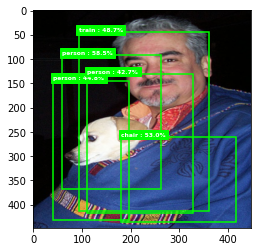

In [26]:
'''
==============
IMPORTANT NOTE :
=============

This is an Implementation of Object Detection using YOLO V1 trained on Pascal VOC Dataset.
==> MODEL SUMMARY :
Total params: 85,787,534
Trainable params: 85,787,534
Non-trainable params: 0
----------------------------------------------------------------
Forward/backward pass size (MB): 436.81
Params size (MB): 327.25
Estimated Total Size (MB): 766.36
----------------------------------------------------------------

detection_list = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                     'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                     'dog', 'horse', 'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

This model can detect only the objects listed in the above detection list.

==> THE MODEL MAY SOMETIMES PRODUCE INCORRECT PREDICTIONS & NEEDS TO TRAINED
FOR MORE EPOCHS TO INCREASE ACCURACY.

==> Images are resized to 448x448 since the model accepts a fixed size image as input.

Each bounding box displays the object name it has detected and the
probability of an object being present inside the bounding box.

(GPU RECOMMENDED FOR RUNNING THE MODEL)

'''

# -------------------------------------------------------------------------

'''
Below is an simple API function of the model which takes the location of your image as
input & then displays the image back with detected objects represented under bounding boxes.

The function also takes an important parameter 'weights_path' which is the path where the 
pretrained weights of the model are located.Given a path it'll load 
those learned parameters into the model (IMPORTANT TO SPECIFY ELSE MODEL WONT WORK)
'''
# -------------------------------------------------------------------------

'''
Due to RAM issues on syster, it only trained on 100 images and that is why prediction is inaccurate. Feel free to
implement on huge dataset if system satisfies requirements. 

'''

# Insert the location of your Image below
IMAGE_PATH = r'../input/pascalvoc-yolo/images/000001.jpg'

# Insert the location of weights file below
WEIGHTS_PATH = r'./YoloV1_Weights.pth'

detect_objects(image_path=IMAGE_PATH,weights_path=WEIGHTS_PATH)